### Notebook总结

通过对custom数据处理和训练流程理解了以下内容：

1. 玩具data中的数据是经过编排的，一开始的处理不需要我们花很多时间，但是大部分的custom需要经过Imagefolder等包的处理，还需要手动进行数据增强等环节。所以custom数据的处理更加复杂。
2. 即使是使用了数据增强也不一定得到好的结果，需要后续的迁移学习。

### 库和数据准备
pytorch有很多自己的框架比如torchvision，torchtext他们是用于不同问题任务的库，而他们的内部都有自己的dataset。

In [1]:
import torch
from torch import nn
torch.__version__

'2.1.2'

In [2]:
# setup device agnostic code
device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"
device

device(type='mps')

首先从一个小的数据集开始，比如不是101种而是3种分类的问题，底层原理是一样的但是却可以更清晰的更快捷的进行实验。Let's Experiment!

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

data/pizza_steak_sushi directory exists.


用大量的时间进行数据准备！查看数据集的结构，将它准备为pytorch可以处理的张量，batch，dataloader。

In [4]:
# use os.walk()
from pathlib import Path
# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"
import os
def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents
    Args:
    -----
        dir_path (str or pathlib.Path):target directory

    Returns:
    -----
        A print out of:
        number of subdiretories in dir_path
        number of images files in each subdirectory
        name of each subdirectory
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi.
There are 3 directories and 0 images in data/pizza_steak_sushi/test.
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak.
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi.
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza.
There are 3 directories and 0 images in data/pizza_steak_sushi/train.
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak.
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi.
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza.


In [6]:
# setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### Pathlib包的使用和图片可视化，也可以使用matplotlib可视化，两种方法

使用pathlib.Path.glob()找到所有的图片文件。

---
`pathlib.Path.glob()`是 `pathlib` 模組提供的一個方法，用於通過樣式匹配返回符合條件的文件或目錄的生成器。

具體來說，`glob()` 方法接受一個模式字符串作為參數，該模式字符串可以包含通配符（例如 `*` 和 `?`），並且它會返回一個生成器，該生成器生成與模式匹配的所有文件或目錄的 `Path` 對象。

以下是一個簡單的示例：

```python
from pathlib import Path

# 在當前目錄中查找所有以 .txt 結尾的文件
for file_path in Path('.').glob('*.txt'):
    print(file_path)
```

上面的例子會列印出當前目錄中所有以 `.txt` 結尾的文件的路徑。 `glob()` 方法的主要用途是方便地遍歷符合特定模式的文件或目錄。

---
返回类名的方法：
`parent` 屬性是 `pathlib.Path` 對象的一個屬性，它返回該路徑對象的父目錄。而 `stem` 屬性則是返回不帶有文件擴展名的文件名部分。

如果你使用 `parent.stem`，則代表取得該路徑的父目錄的文件名部分（不包括擴展名）。

以下是一個簡單的示例：

```python
from pathlib import Path

file_path = Path('/path/to/parent/file.txt')

# 取得父目錄的文件名部分
parent_stem = file_path.parent.stem

print(parent_stem)
```

在這個例子中，`file_path.parent` 將是 `/path/to/parent`，而 `file_path.parent.stem` 將返回 `parent`。這是由於 `parent` 返回的是一個 `Path` 對象，而 `stem` 返回該路徑的文件名部分。

---

打开文件使用`PIL.Image.open()`

In [7]:
# exsample
from pathlib import Path

file_path = Path('/path/to/parent/file.txt')

# 取得父目錄的文件名部分
parent_stem = file_path.parent.stem

print(parent_stem)

parent


Random image path: data/pizza_steak_sushi/test/pizza/2236338.jpg
Image class: pizza
Image height: 512
Image width: 512


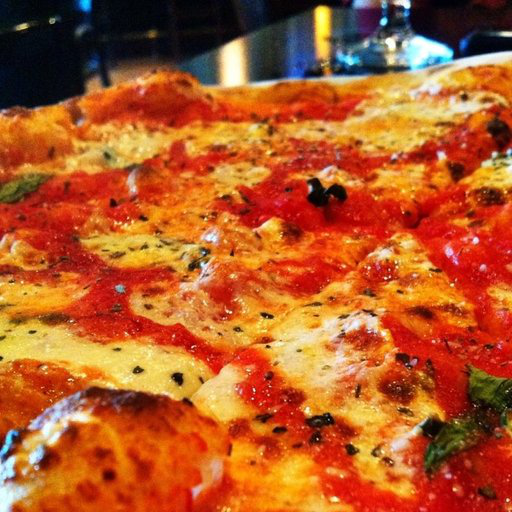

In [8]:
import random
from PIL import Image

# seed seed
random.seed(42)

# 1, get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2, get random image path
random_image_path = random.choice(image_path_list)

# 3, get image class from path name
image_class = random_image_path.parent.stem

# 4, open image
img = Image.open(random_image_path)

# 5, print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

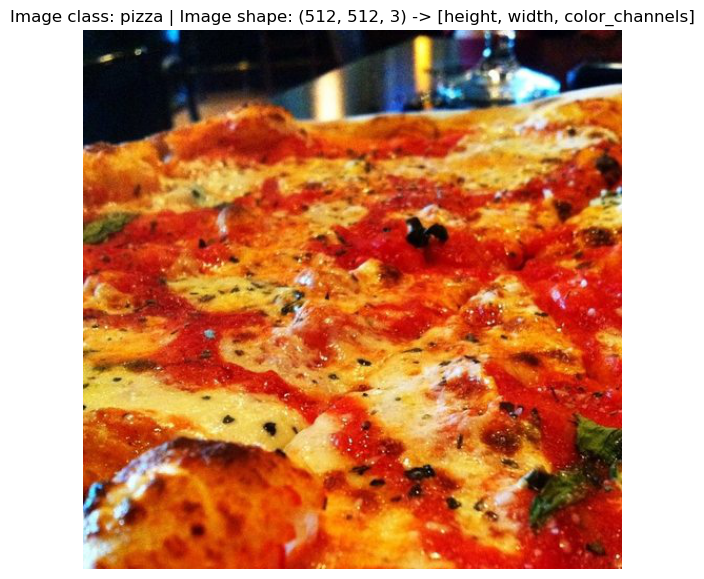

In [9]:
# can use matplotlib as well, have to convert the image to numpy array
import numpy as np
import matplotlib.pyplot as plt

# turn the image into an array
img_as_array = np.asarray(img)

# plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

### 数据转换

要将图片数据加载进pytorch，需要进行张量转换to tensor，以及用dataloader(utils.data.DataLoader)将图片(utils.data.Dataset)打成批次以便后续进行训练。

In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [11]:
# transform data with torchvision.transfroms
# write transform for image
data_transform = transforms.Compose([
    # resize the images to 64 x 64
    transforms.Resize(size=(64, 64)),
    # flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p is probability of flip
    # turn the image into a torch.Tensor
    transforms.ToTensor()  # converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

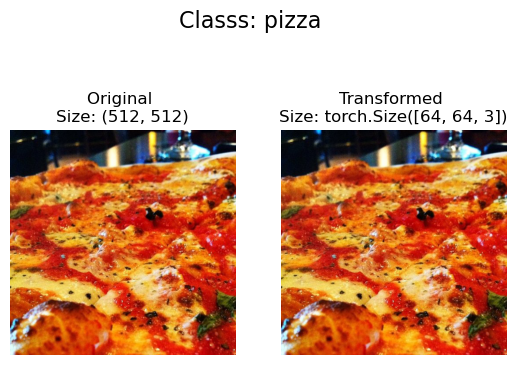

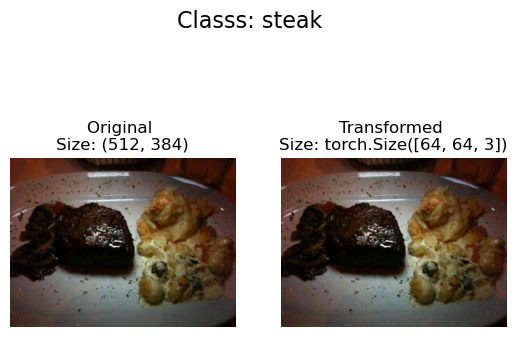

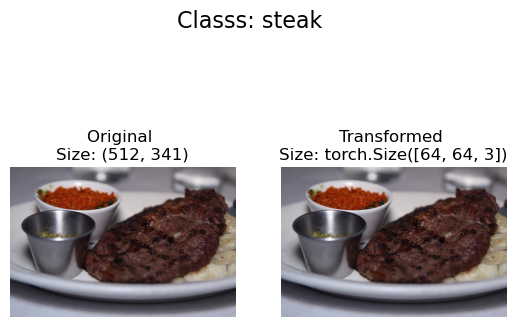

In [12]:
# create a function to try the result of data transform
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            transformed_image = transform(f).permute(1, 2, 0) # put color channel to the last position
            ax[1].imshow(f)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Classs: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

### **torchvision的datasets.ImageFolder**: 使用Pytorch的ImageFolder，载入数据集。

In [13]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)
print(f"Tranin data:\n{train_data}\nTest data:\n{test_data}")

Tranin data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [14]:
# get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [15]:
# can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [16]:
# check the lengths
len(train_data), len(test_data)

(225, 75)

In [17]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0706, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0196, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

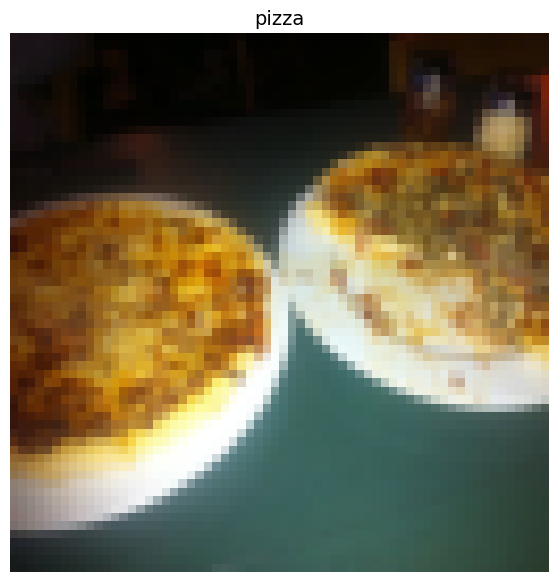

In [18]:
# visualize
# remember to rearrange the order of dimensions
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

### 将数据打包成批次：torch.utils.data.DataLoader

In [17]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1,
                              num_workers=1,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x13f9014d0>,
 <torch.utils.data.dataloader.DataLoader at 0x13f8c9bd0>)

In [18]:
# try it and check the shapes
img, label = next(iter(train_dataloader))
# batch size will now be 1, try changing the batch_size parameter above and see what happens
img.shape, label.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

### （Option）如果我我们没有ImageFolder，我们要怎么做，通过手动create自己的method，可以了解ImageFolder到底做了什么。

虽然是手动我们其实**可以实现各种事情**但是需要写更多code，并且有时候它不一定起作用。但是这是一种学习的好方法。

下面是create custom dataset class相当于手动实现ImageFolder。

因为所有的custom datasets，还有ImageFolder是build-on torch.utils.data.Dataset上的子集，所以下面也是在这个基础上构建。

In [48]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [49]:
# create a helper function to get class names
target_directory = train_dir
print(target_directory)

class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
class_names_found

data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [50]:
# make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """ Find the class folder names in a target directory.
    Assumes target directory is in standard image classification format.
    Returns:
    Tuple(list_of_class_names, dict(class_name: index))"""
    # 1, get the class names by scanning the directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    # 2, raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
    # 3, create a directory of index labels
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [51]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

流程：
1. 初始化一个torch.utils.data.Dataset的子类
2. 初始化这个子类的参数：目标文件夹，transform，之类的
3. 创建几个初始化属性：paths，transform，classes，class_to_idx
4. 创建一个function用来载入图像，使用PIL或者torchvision.io库
5. 重写父类的__len__方法
6. 重写父类的__getitem__方法

In [52]:
# write a custom dataset class
from torch.utils.data import Dataset

# 1, subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    # 2, initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir, transform=None):
        # 3, create class attributes
        # get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        # set up transform
        self.transform = transform
        # create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4, create function to load images
    def load_image(self, index):
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5, overwrite the __len__() method
    def __len__(self):
        return len(self.paths)

    # 6, overwrite the __getitem__() method
    def __getitem__(self, index):
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]
        # transform if necessary 
        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx

In [53]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [54]:
# try to use the custom class
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x13c05e590>,
 <__main__.ImageFolderCustom at 0x13c055dd0>)

In [56]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [57]:
train_data_custom.classes, train_data_custom.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 创建一个函数用来显示随机图片。

1. 参数是，数据集，类，展示数量，seed
2. 调整展示数量，尽量不超过10张
3. set seed
4. random.sample() 选择一些index图片
5. 组织matplotlib plot
6. loop这些图片
7. 确保sample images的格式是HWC

In [20]:
# 1, take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: list[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    # 2, adjust display if n too high
    if n >= 10:
        n = 10
        display_shape = False
        print(f"For display perposes, n shouldn't be larger than 10, setting to 10, and removing shape display.")

    # 3, set random seed
    if seed:
        random.seed(seed)

    # 4, get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5, setup plot
    plt.figure(figsize=(16, 8))

    # 6, loop through samples and display random samples
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7, adjust image tensor shape for plotting
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # plot adjusted samples
        plt.subplot(1, n, i + 1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

For display perposes, n shouldn't be larger than 10, setting to 10, and removing shape display.


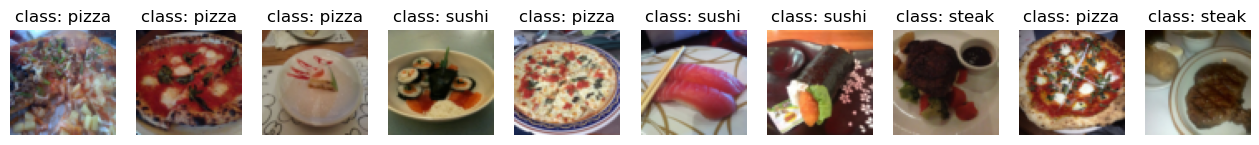

In [21]:
display_random_images(train_data, 
                      n=12, 
                      classes=class_names,
                      seed=None)

In [66]:
# turn train and test custom dataset's into DataLoader's
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=1,
                                     num_workers=0,
                                     shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=1,
                                    num_workers=0,
                                    shuffle=False)
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x16b6c6590>,
 <torch.utils.data.dataloader.DataLoader at 0x16bc9ced0>)

In [68]:
img_custom, label_custom = next(iter(train_dataloader_custom))
img_custom.shape, label_custom.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

机器学习就是利用随机性的力量，研究表明随机变换（如transforms.RandAugment()和transforms.TrivialAugmentWide()）通常比手工选择的变换表现得更好。

trivial这个词是微不足道的意思，简单的力量。

TrivialAugment 是最近对各种 PyTorch 视觉模型进行最先进的训练升级时使用的成分之一。

transforms.TrivialAugmentWide()需要注意的主要参数是num_magnitude_bins=31。

它定义了将选择多少范围的强度值来应用某种变换，0即无范围和31最大范围（最高强度的最高机会）。

In [24]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# don't need to perform augmentation on the test data
test_trainsforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

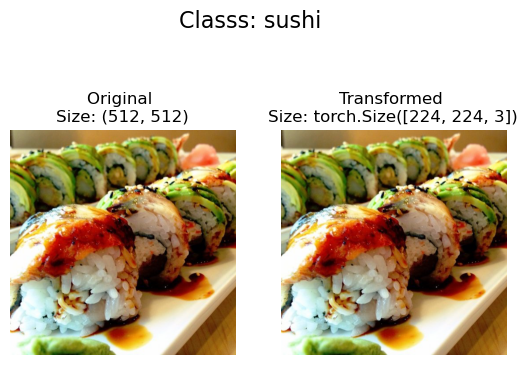

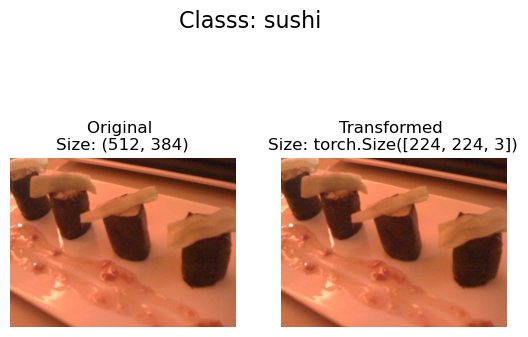

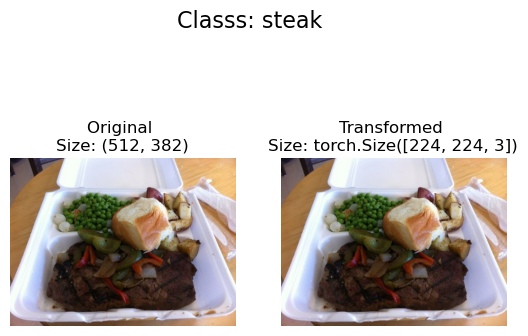

In [25]:
# gat all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
# plot random images
plot_transformed_images(
    image_paths = image_path_list,
    transform = train_transforms,
    n = 3, 
    seed = None
)

### Model 0 :TinyVGG without data augmentation（学习过拟合，以及各种helper函数）

In [26]:
# start with a simple transform, only resizing the images to (64, 64)
from torchvision import transforms
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [27]:
# 1, Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# 2, Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Create dataloader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# create DataLoader's
train_dataloader_simple = DataLoader(train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)
test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)
train_dataloader_simple, test_dataloader_simple

Create dataloader's with batch size 32 and 8 workers.


(<torch.utils.data.dataloader.DataLoader at 0x3007c6010>,
 <torch.utils.data.dataloader.DataLoader at 0x300188490>)

In [28]:
# create model
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)            
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        # x = self.conv_block_1(x)
        # x = self.conv_block_2(x)
        # x = self.classifier(x)
        # return x
        # to save time:
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

输出分类层的时候，16*16，是因为在上面经过两次最大池化的变换，图像尺寸从64边长变成了32边长，又变成了16边长的结果。

next:test model 0's forward()

1. 从dataloader中取出一个图片
2. 进行unsqueeze处理
3. 推理
4. 变换结果

In [29]:
# 1, get a batch of images and labels from the dataloader
img_batch, label_batch = next(iter(train_dataloader_simple))

# 2, get a single image from the batch and unsqueeze the image
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3, perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))

# 4, print out converted result
print(f"Logits: {pred}\n")
print(f"Pred probabilities: {torch.softmax(pred, dim=1)}\n")
print(f"Prediction label: {torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"True label: {label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Logits: tensor([[0.0578, 0.0634, 0.0352]], device='mps:0')

Pred probabilities: tensor([[0.3352, 0.3371, 0.3277]], device='mps:0')

Prediction label: tensor([1], device='mps:0')

True label: 2


上面的结果很错误，那是因为现在的权重都是随机权重。

使用torchinfo可以打印张量经过模型时候的信息。

In [30]:
# install torchinfo if it's not available
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

创建用于train和test循环的函数。在之前的部分也有写过。

In [31]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # put model in train mode
    model.train()

    # setup train loss and train accuracy valuesl
    train_loss, train_acc = 0, 0

    # loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # send data to target device
        X, y = X.to(device), y.to(device)
        # 1, Forward pass
        y_pred = model(X)
        # 2, Calculate and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        # 3, Optimizer zero grad
        optimizer.zero_grad()
        # 4, loss backward()
        loss.backward()
        # 5, optimizer step
        optimizer.step()
        # calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    # adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

不是很懂loss为什么需要item提取，所以下面是自己做的实验

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim

# 定义模型、损失函数和优化器
model_test = torch.nn.Linear(10, 1)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model_test.parameters(), lr=0.01)

# 假设有输入数据 input_data 和目标标签 target
input_data = torch.randn(5, 10)
print(input_data)
target = torch.randn(5, 1)
print(target)

# 前向传播
output = model_test(input_data)

# 计算损失
loss = loss_fn(output, target)
print(loss)

# 提取标量值
loss_value = loss.item()
print(loss_value)

# 反向传播和参数更新
optimizer.zero_grad()
loss.backward()
optimizer.step()

tensor([[ 1.5560,  0.6210,  0.4261, -0.5067, -0.6826,  1.2044,  2.0234,  0.5329,
          0.0837, -0.2783],
        [ 0.8009,  0.7966,  0.0479,  0.1020, -0.3104,  0.7765, -0.2236, -0.8170,
          1.2408, -1.8672],
        [-1.5295, -1.0727, -1.8543, -0.3320,  0.7897, -0.5336,  0.1860,  1.3890,
          0.6058,  1.6549],
        [-0.3503,  0.9058, -0.2507, -0.6016, -0.4817, -0.2800,  0.1683, -0.3792,
         -2.0799,  1.3892],
        [-0.7659,  0.4537,  0.3607,  1.4388, -0.8794,  0.3353,  1.2280,  0.5652,
         -0.0444, -1.2237]])
tensor([[-0.1319],
        [-0.1755],
        [-0.9547],
        [ 0.3813],
        [ 1.7338]])
tensor(0.6604, grad_fn=<MseLossBackward0>)
0.6603927612304688


In [32]:
def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module
):
    # put model in eval mode
    model.eval()

    # setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # turn on inference context manager
    with torch.inference_mode():
        # loop through dataloader batches
        for batch, (X, y) in enumerate(dataloader):
            # send data to target device
            X, y = X.to(device), y.to(device)

            # 1, forward pass
            test_pred_logits = model(X)

            # 2, calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))

    # adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [33]:
# create train function 
# 1. take in various parameters 
def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
    epochs: int = 5
):
    # 2. create empty results dictionary
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. loop through training and test steps for a number of epochs
    for epoch in range(epochs):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer
        )
        test_loss, test_acc = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn
        )

        # 4. print out
        print(
            f"Epoch: {epoch + 1} |"
            f"train_loss: {train_loss:.4f} |"
            f"train_acc: {train_acc:.4f} |"
            f"test_loss: {test_loss:.4f} |"
            f"test_acc: {test_acc:.4f} |"
        )

        # 5. update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [34]:
# train and evaluate model 0
# set random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set number of epochs
NUM_EPOCHS = 5

# recreate an instance of TinyVGG
model_0 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data.classes)
).to(device)

# setup loss fuction and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# start the timer
from timeit import default_timer as timer
start_time = timer()

# train model_0
model_0_results = train(
    model=model_0,
    train_dataloader=train_dataloader_simple,
    test_dataloader=test_dataloader_simple,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=NUM_EPOCHS
)

# end the timer and print out
end_time = timer()
print(f"Total training time: {end_time - start_time :.3f} seconds.")

Epoch: 1 |train_loss: 1.1078 |train_acc: 0.2578 |test_loss: 0.0000 |test_acc: 0.2604 |
Epoch: 2 |train_loss: 1.0847 |train_acc: 0.4258 |test_loss: 0.0000 |test_acc: 0.1979 |
Epoch: 3 |train_loss: 1.1157 |train_acc: 0.2930 |test_loss: 0.0000 |test_acc: 0.1979 |
Epoch: 4 |train_loss: 1.0955 |train_acc: 0.4141 |test_loss: 0.0000 |test_acc: 0.1979 |
Epoch: 5 |train_loss: 1.0985 |train_acc: 0.2930 |test_loss: 0.0000 |test_acc: 0.1979 |
Total training time: 323.005 seconds.


In [35]:
# check the model 0 results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [36]:
# create a function to plot training loss curve
def plot_loss_curves(results):
    """Plot trainin curves of a results dictionary.
    Args:
        result (dict): dictionary containing list of values, e.g
    """
    # get the loss and acc values of the results
    train_loss = results["train_loss"]
    test_loss = results["test_loss"]
    train_acc = results["train_acc"]
    test_acc = results["test_acc"]

    # figure out how many epochs there were
    epochs = range(len(results["train_loss"]))

    # setup a plot
    plt.figure(figsize=(15, 7))

    # plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # plot acc
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label="train_acc")
    plt.plot(epochs, test_acc, label="test_acc")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend();

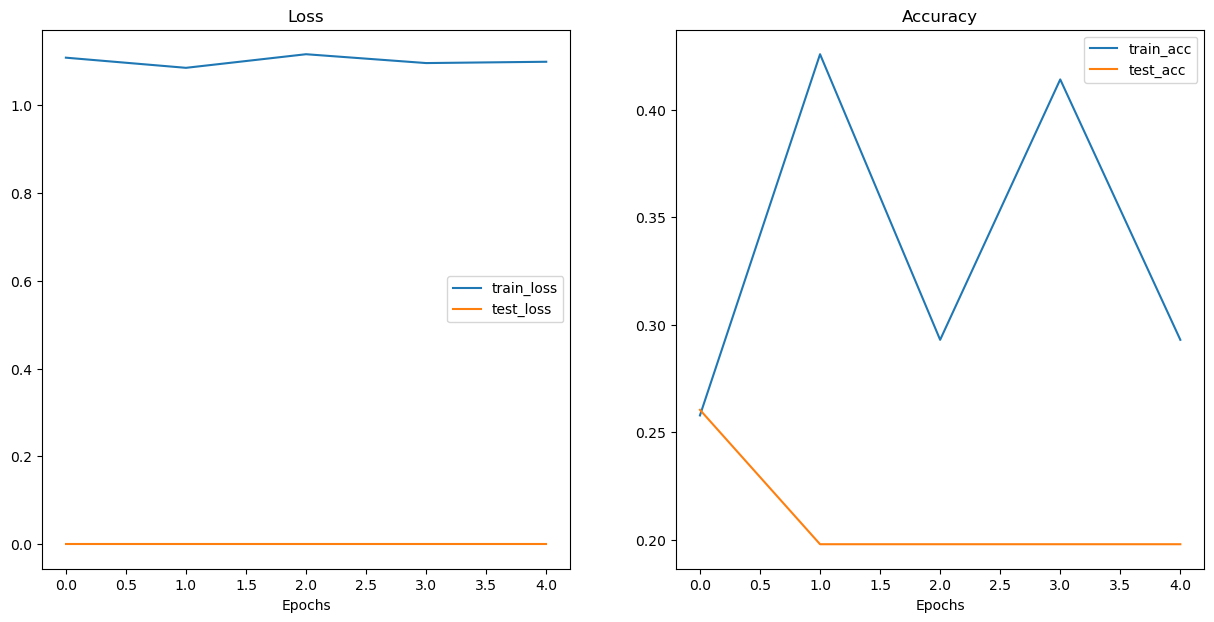

In [37]:
plot_loss_curves(model_0_results)

过拟合防止：

* 更多数据
* 简化模型
* 数据增强
* 迁移学习
* dropout
* lr decay
* early stopping

欠拟合防止：

* 更多层/神经元
* 调整学习率
* 迁移学习
* 更多epochs
* 更少正则化

### Model 1 with all same with model 0 except data augmented TrivialAugment！

In [38]:
# create training transforms
from torchvision import transforms
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),    
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [39]:
# turn image folder into datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [40]:
# turn datasets into dataloader's
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)
train_dataloader_augmented, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x302159cd0>,
 <torch.utils.data.dataloader.DataLoader at 0x17ffe3e90>)

In [41]:
# create model 1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_augmented.classes)
).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [42]:
# train and evaluate model 1
# set random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set number of epochs
NUM_EPOCHS = 5

# setup loss fuction and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# start the timer
from timeit import default_timer as timer
start_time = timer()

# train model_1
model_1_results = train(
    model=model_1,
    train_dataloader=train_dataloader_augmented,
    test_dataloader=test_dataloader_simple,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=NUM_EPOCHS
)

# end the timer and print out
end_time = timer()
print(f"Total training time: {end_time - start_time :.3f} seconds.")

Epoch: 1 |train_loss: 1.1074 |train_acc: 0.2500 |test_loss: 0.0000 |test_acc: 0.2604 |
Epoch: 2 |train_loss: 1.0791 |train_acc: 0.4258 |test_loss: 0.0000 |test_acc: 0.2604 |
Epoch: 3 |train_loss: 1.0803 |train_acc: 0.4258 |test_loss: 0.0000 |test_acc: 0.2604 |
Epoch: 4 |train_loss: 1.1285 |train_acc: 0.3047 |test_loss: 0.0000 |test_acc: 0.2604 |
Epoch: 5 |train_loss: 1.0878 |train_acc: 0.4258 |test_loss: 0.0000 |test_acc: 0.2604 |
Total training time: 318.879 seconds.


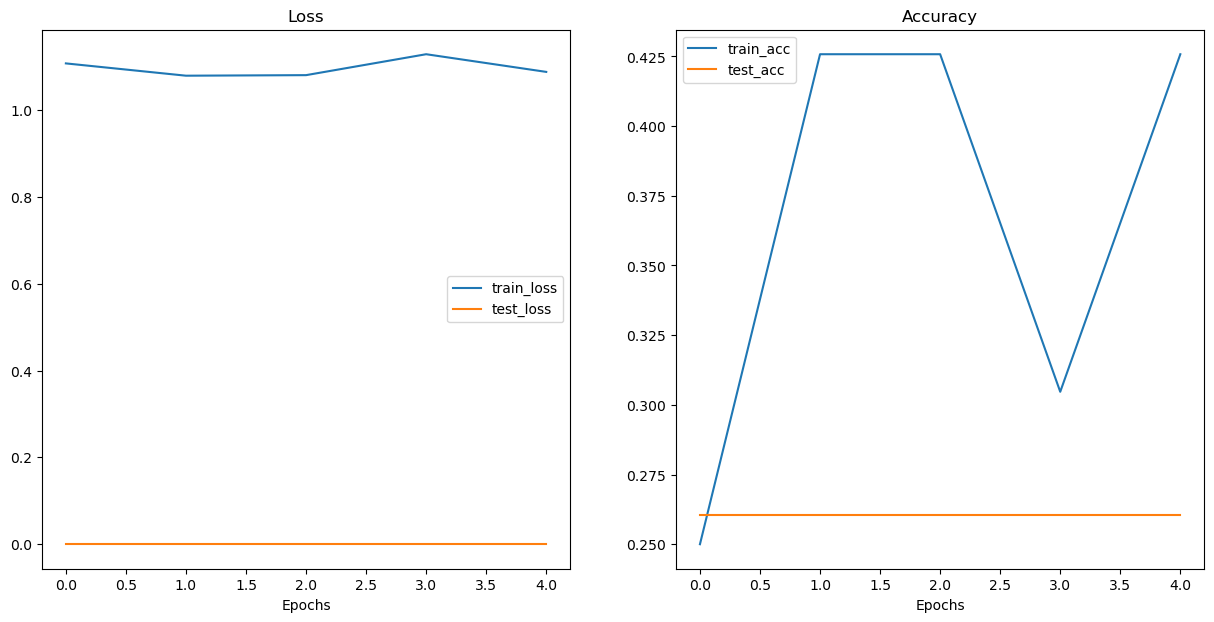

In [43]:
# plot the loss curve
plot_loss_curves(model_1_results)

### Compare model results

In [60]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.107833,0.257812,0.0,0.260417
1,1.084712,0.425781,0.0,0.197917
2,1.115689,0.292969,0.0,0.197917
3,1.095546,0.414062,0.0,0.197917
4,1.098520,0.292969,0.0,0.197917


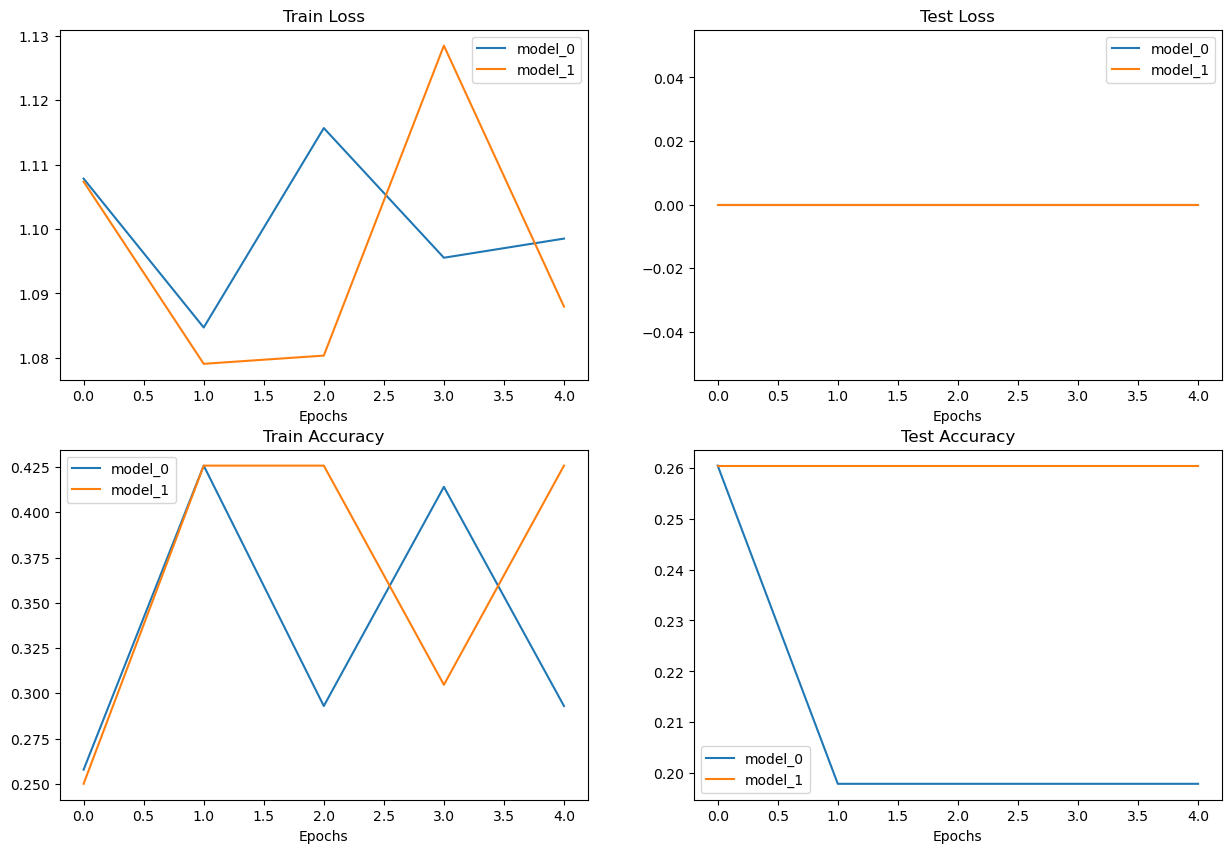

In [61]:
# setup a plot
plt.figure(figsize=(15, 10))
# get number of epochs
epochs = range(len(model_0_df))

# plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="model_0")
plt.plot(epochs, model_1_df["train_loss"], label="model_1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="model_0")
plt.plot(epochs, model_1_df["test_loss"], label="model_1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# plot train acc
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="model_0")
plt.plot(epochs, model_1_df["train_acc"], label="model_1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# plot test acc
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="model_0")
plt.plot(epochs, model_1_df["test_acc"], label="model_1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend()

### Make predictions on custom data

* load image
* type to float32
* to same device
* resize by transform
* unsqueeze to be batch shape
* get logit
* softmax it to probs
* argmax to get label

In [63]:
# get data
import requests

# setup custom image path 
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

In [70]:
import torchvision
# make a function to predict on custom data
def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names = None,
    transform = None,
    device: torch.device=device
):
    # 1. load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    # 2. divide the image pixel values by 255 to get them between 0 and 1
    target_image = target_image / 255.
    # 3. transform if necessary
    if transform:
        target_image = transform(target_image)
    # 4. make sure the model is on the target device
    model.to(device)
    # 5. turn on model evaluation model and inference mode
    model.eval()
    with torch.inference_mode():
        # add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)
        # make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))
    # 6. convert logits
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    # 7. convert pred probs to labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    # 8. plot the image along side the prediction and probs
    plt.imshow(target_image.squeeze().permute(1, 2, 0))
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

In [71]:
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64))
])

/Users/sallyw/machine-learning-lab/mlztm/env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


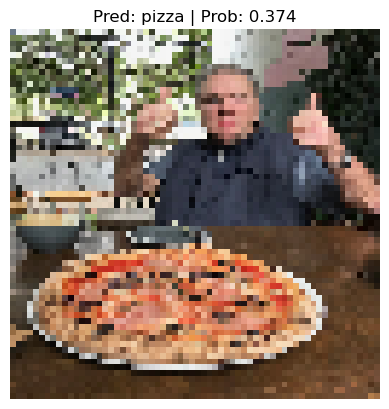

In [72]:
pred_and_plot_image(
    model=model_1,
    image_path=custom_image_path,
    class_names=class_names,
    transform=custom_image_transform,
    device=device
)